## Color adaptation with OT mapping estimation

Demo of Optimal transport for domain adaptation with image color adaptation as in [6] with mapping estimation from [8]

[6] Ferradans, S., Papadakis, N., Peyré, G., & Aujol, J. F. (2014). Regularized
    discrete optimal transport. SIAM Journal on Imaging Sciences, 7(3), 1853-1882.
    
[8] M. Perrot, N. Courty, R. Flamary, A. Habrard, "Mapping estimation for
    discrete optimal transport", Neural Information Processing Systems (NIPS), 2016.


In [1]:
import numpy as np
import scipy.ndimage as spi
import matplotlib.pylab as pl
import ot


### Loading and plotting images

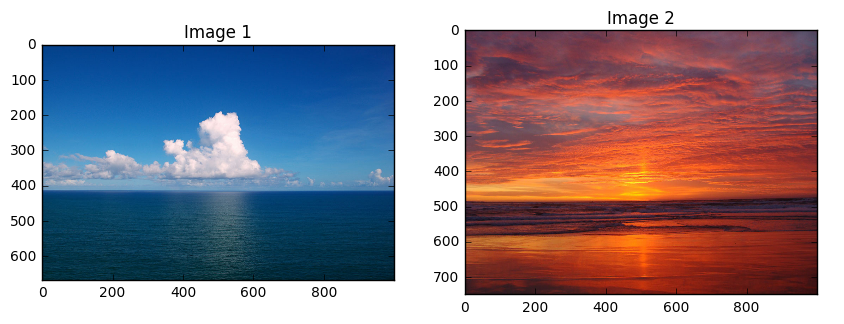

In [2]:
I1=spi.imread('../data/ocean_day.jpg').astype(np.float64)/256
I2=spi.imread('../data/ocean_sunset.jpg').astype(np.float64)/256

#%% Plot images

pl.figure(1,(10,5))

pl.subplot(1,2,1)
pl.imshow(I1)
pl.title('Image 1')

pl.subplot(1,2,2)
pl.imshow(I2)
pl.title('Image 2')

pl.show()

### Image conversion (toi matrices) and subsampling

In [3]:
def im2mat(I):
    """Converts and image to matrix (one pixel per line)"""
    return I.reshape((I.shape[0]*I.shape[1],I.shape[2]))

def mat2im(X,shape):
    """Converts back a matrix to an image"""
    return X.reshape(shape)

X1=im2mat(I1)
X2=im2mat(I2)

# training samples
nb=1000
idx1=np.random.randint(X1.shape[0],size=(nb,))
idx2=np.random.randint(X2.shape[0],size=(nb,))

xs=X1[idx1,:]
xt=X2[idx2,:]

### Plot image distributions

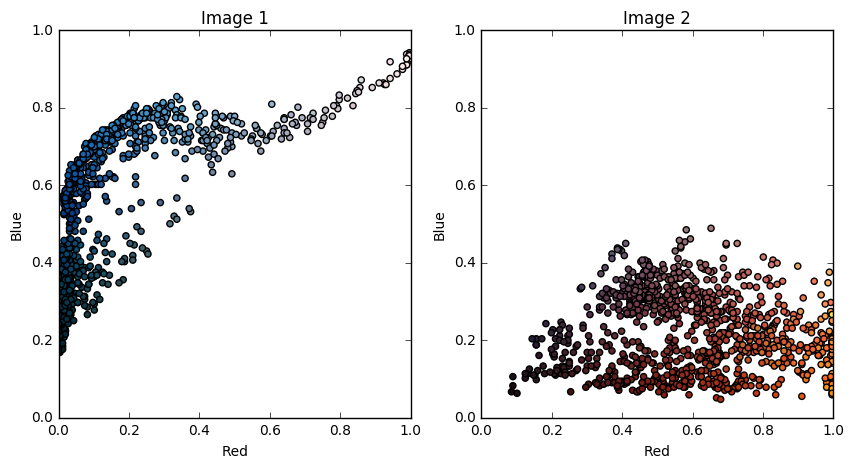

In [4]:
pl.figure(2,(10,5))

pl.subplot(1,2,1)
pl.scatter(xs[:,0],xs[:,2],c=xs)
pl.axis([0,1,0,1])
pl.xlabel('Red')
pl.ylabel('Blue')
pl.title('Image 1')

pl.subplot(1,2,2)
#pl.imshow(I2)
pl.scatter(xt[:,0],xt[:,2],c=xt)
pl.axis([0,1,0,1])
pl.xlabel('Red')
pl.ylabel('Blue')
pl.title('Image 2')

pl.show()


### Domain adaptation and mapping between images

In [5]:
def minmax(I):
    return np.minimum(np.maximum(I,0),1)
# LP problem
da_emd=ot.da.OTDA()     # init class
da_emd.fit(xs,xt)       # fit distributions

X1t=da_emd.predict(X1)  # out of sample
I1t=minmax(mat2im(X1t,I1.shape))

# sinkhorn regularization
lambd=1e-1
da_entrop=ot.da.OTDA_sinkhorn()
da_entrop.fit(xs,xt,reg=lambd)

X1te=da_entrop.predict(X1)
I1te=minmax(mat2im(X1te,I1.shape))

# linear mapping estimation
eta=1e-8   # quadratic regularization for regression
mu=1e0     # weight of the OT linear term
bias=True  # estimate a bias

ot_mapping=ot.da.OTDA_mapping_linear()
ot_mapping.fit(xs,xt,mu=mu,eta=eta,bias=bias,numItermax = 20,verbose=True)

X1tl=ot_mapping.predict(X1) # use the estimated mapping
I1tl=minmax(mat2im(X1tl,I1.shape))

# nonlinear mapping estimation
eta=1e-2   # quadratic regularization for regression
mu=1e0     # weight of the OT linear term
bias=False  # estimate a bias
sigma=1    # sigma bandwidth fot gaussian kernel


ot_mapping_kernel=ot.da.OTDA_mapping_kernel()
ot_mapping_kernel.fit(xs,xt,mu=mu,eta=eta,sigma=sigma,bias=bias,numItermax = 10,verbose=True)

X1tn=ot_mapping_kernel.predict(X1) # use the estimated mapping
I1tn=minmax(mat2im(X1tn,I1.shape))

It.  |Loss        |Delta loss
--------------------------------
    0|3.699980e+02|0.000000e+00
    1|3.608346e+02|-2.476614e-02
    2|3.606710e+02|-4.534048e-04
    3|3.605854e+02|-2.373172e-04
    4|3.605308e+02|-1.515104e-04
    5|3.604930e+02|-1.048652e-04
    6|3.604655e+02|-7.607409e-05
    7|3.604444e+02|-5.868306e-05
    8|3.604277e+02|-4.642246e-05
    9|3.604141e+02|-3.764735e-05
   10|3.604028e+02|-3.124268e-05
   11|3.603933e+02|-2.632307e-05
   12|3.603852e+02|-2.260049e-05
   13|3.603782e+02|-1.938188e-05
   14|3.603721e+02|-1.706719e-05
   15|3.603667e+02|-1.489910e-05
   16|3.603619e+02|-1.336306e-05
   17|3.603576e+02|-1.189587e-05
   18|3.603537e+02|-1.066658e-05
   19|3.603534e+02|-9.986781e-07
It.  |Loss        |Delta loss
--------------------------------
    0|3.619308e+02|0.000000e+00
    1|3.568950e+02|-1.391388e-02
    2|3.567799e+02|-3.225305e-04
    3|3.567404e+02|-1.105949e-04
    4|3.567137e+02|-7.490749e-05
    5|3.566940e+02|-5.504299e-05
    6|3.566790e+02

### Plotting adapted images

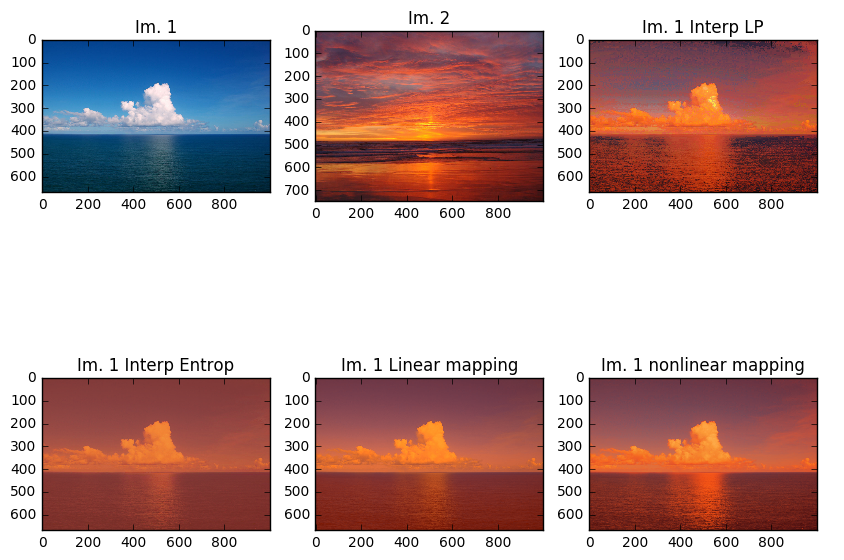

In [6]:
#%% plot images


pl.figure(2,(10,8))

pl.subplot(2,3,1)

pl.imshow(I1)
pl.title('Im. 1')

pl.subplot(2,3,2)

pl.imshow(I2)
pl.title('Im. 2')


pl.subplot(2,3,3)
pl.imshow(I1t)
pl.title('Im. 1 Interp LP')

pl.subplot(2,3,4)
pl.imshow(I1te)
pl.title('Im. 1 Interp Entrop')


pl.subplot(2,3,5)
pl.imshow(I1tl)
pl.title('Im. 1 Linear mapping')

pl.subplot(2,3,6)
pl.imshow(I1tn)
pl.title('Im. 1 nonlinear mapping')

pl.show()